In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
import numpy as np

dim=150
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

FD_StencilMat=np.zeros((dim,dim))
b = np.ones(dim-1)
c = -2*np.ones(dim)
np.fill_diagonal(FD_StencilMat[1:], b)
np.fill_diagonal(FD_StencilMat[:,1:], b)
np.fill_diagonal(FD_StencilMat, c)
A=FD_StencilMat
A=np.asmatrix(A)
AType='1D Laplacian'

retrain_freq=1
e1 = 1e-4
e2 = 1e-7
nmax_iter = 50
restart   = 64

sigma=0.02
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =2000
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("Benchmark 150 dim problem. Linear gradient RHS. Linear conv ONLY")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-08 02:16:10 [INFO] <ipython-input-4-0da62f1143a2> 2 - Benchmark 150 dim problem. Linear gradient RHS. Linear conv ONLY


In [5]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *



ML_GMRES_Time_list=[]
Err_list=[]
GmresRunTimeOriginal=[]

trainTime_list=[]
NonML_Err_List=[]
run_time_ML_list=[]
run_time_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
#     b=Gauss_pdf(x,loc,sigma)
    b=(np.sin(ProbIdx)+.0001)*np.maximum(x-loc,0)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]

    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
    GmresRunTimeOriginal.append(run_time1)
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    run_time_list.append(run_time1+run_time2)
    
    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
Final loss: 1611010.75
parameters 45000
Initial Training
2
size 52
0.8691210437904151 0.9083394874735551
0.5009237360209227 0.47682178649120033 0.8691210437904151 0.842811618479838
0.5009237360209227 0.47682178649120033 0.8691210437904151 0.842811618479838
3
size 52
0.7724615255043432 0.9083394874735551
0.4043616419949103 0.47592113600694574 0.7724615255043432 0.8507628773610749
0.4043616419949103 0.47592113600694574 0.7724615255043432 0.8507628773610749
4
size 52
0.6337507314349055 0.9083394874735551
0.37451957698795013 0.45206797133626725 0.6337507314349055 0.8246624267421643
0.37451957698795013 0.45206797133626725 0.6337507314349055 0.8246624267421643
5
size 52
0.8595692118074326 0.9083394874735551
0.5031787850020919 0.4266016516679277 0.8595692118074326 0.7584444335765546
0.5031787850020919 0.4266016516679277 0.8595692118074326 0.7584444335765546
6
size 52
0.9022417218580909 0.9083394874735551
0.5322098710166756 0.44574593500146875 0.9022417218580909 0.783725628134274
0.5322098

35
size 52
1.1856628130255285 0.9517589160320589
poor prediction,using initial x0
0.522845422005048 0.47460523200570603 0.9414509794285961 0.8189289641931752
0.522845422005048 0.47460523200570603 0.9414509794285961 0.8189289641931752
InnerProd [[ 1.         -0.99839194 -0.99824619]
 [-0.99839194  1.          0.99999679]
 [-0.99824619  0.99999679  1.        ]]
retraining
1
Final loss: 11256100.0
parameters 45000
36
size 52
1.2885140041628642 0.9517589160320589
poor prediction,using initial x0
0.5396109989960678 0.47496345100575127 0.9516519639334877 0.8188547240942522
0.5396109989960678 0.47496345100575127 0.9516519639334877 0.8188547240942522
37
size 52
0.9720306531629558 0.9517589160320589
poor prediction,using initial x0
0.5635858020104934 0.4756328995653894 0.913307229963408 0.8194532606832187
0.5635858020104934 0.4756328995653894 0.913307229963408 0.8194532606832187
38
size 52
0.8613855730745138 0.9517589160320589
0.4566559520026203 0.477320050324779 0.8613855730745138 0.8208947307

0.5006136450101621 0.43684269264456815 0.9384815855236037 0.7606048968310466
68
size 52
0.9021078873016607 0.9517589160320589
0.42033165000611916 0.43889550404506733 0.9021078873016607 0.7620688683295477
0.42033165000611916 0.43889550404506733 0.9021078873016607 0.7620688683295477
69
size 52
0.8495831030417573 0.9517589160320589
0.42039312300039455 0.4361505321250297 0.8495831030417573 0.7604896563624723
0.42039312300039455 0.4361505321250297 0.8495831030417573 0.7604896563624723
70
size 52
0.4235025471361509 0.9517589160320589
0.25081983298878185 0.43825651532504706 0.4235025471361509 0.7713416478008659
0.25081983298878185 0.43825651532504706 0.4235025471361509 0.7713416478008659
71
size 52
1.3337691945196535 0.9517589160320589
poor prediction,using initial x0
0.5301404790079687 0.4268075383640826 0.9516441821533238 0.7511586536501799
0.5301404790079687 0.4268075383640826 0.9516441821533238 0.7511586536501799
InnerProd [[ 1.          0.99970858 -0.99873762]
 [ 0.99970858  1.         -

101
size 52
0.8304506626350473 0.9517589160320589
0.4202679170120973 0.4025318202783819 0.8304506626350473 0.7406546957642319
0.4202679170120973 0.4025318202783819 0.8304506626350473 0.7406546957642319
102
size 52
1.2821025199043397 0.9517589160320589
poor prediction,using initial x0
0.5323345149809029 0.40824055535835213 0.9508285626119275 0.7606278967578252
0.5323345149809029 0.40824055535835213 0.9508285626119275 0.7606278967578252
InnerProd [[1.         0.97594835 0.99997598]
 [0.97594835 1.         0.97455729]
 [0.99997598 0.97455729 1.        ]]
retraining
1
Final loss: 16814456.0
parameters 45000
103
size 52
0.49693763389882334 0.9517589160320589
0.2824381339887623 0.40847269335761666 0.49693763389882334 0.7607628752968871
0.2824381339887623 0.40847269335761666 0.49693763389882334 0.7607628752968871
104
size 52
0.5074138858178955 0.9517589160320589
0.2826253119856119 0.4052554321964271 0.5074138858178955 0.751140517793481
0.2826253119856119 0.4052554321964271 0.5074138858178955 

0.42115015201852657 0.41357638376066463 0.8135312969260796 0.7204197715534965
135
size 52
1.3459901571664807 0.9517650899697802
poor prediction,using initial x0
0.5307716190000065 0.41819674100144766 0.9516904162031238 0.7366126118588313
0.5307716190000065 0.41819674100144766 0.9516904162031238 0.7366126118588313
InnerProd [[ 1.          0.99712304 -0.98692192]
 [ 0.99712304  1.         -0.9731887 ]
 [-0.98692192 -0.9731887   1.        ]]
retraining
1
Final loss: 18354980.0
parameters 45000
136
size 52
1.126666966414925 0.9517650899697802
poor prediction,using initial x0
0.49958057201001793 0.4238675365212839 0.939220249228978 0.7478010067126426
0.49958057201001793 0.4238675365212839 0.939220249228978 0.7478010067126426
137
size 52
1.1191448147041911 0.9517650899697802
poor prediction,using initial x0
0.499030151986517 0.42397924200166015 0.9382948860061597 0.7477377359471521
0.499030151986517 0.42397924200166015 0.9382948860061597 0.7477377359471521
138
size 52
0.39536411645214703 0.9

169
size 52
0.44548169064074383 0.9517682474885778
0.3339227859978564 0.422794980360195 0.44548169064074383 0.7242515412404635
0.3339227859978564 0.422794980360195 0.44548169064074383 0.7242515412404635
170
size 52
1.1568188352978426 0.9517682474885778
poor prediction,using initial x0
0.5036946829932276 0.42152594024082646 0.941171081298727 0.7248077203398374
0.5036946829932276 0.42152594024082646 0.941171081298727 0.7248077203398374
InnerProd [[ 1.         -0.98852678  0.99571371]
 [-0.98852678  1.         -0.99815326]
 [ 0.99571371 -0.99815326  1.        ]]
retraining
1
Final loss: 18084064.0
parameters 45000
171
size 52
0.3925027539073906 0.9517682474885778
0.39096914598485455 0.4203164351999294 0.3925027539073906 0.7252864114275377
0.39096914598485455 0.4203164351999294 0.3925027539073906 0.7252864114275377
172
size 52
0.7441832186929823 0.9517682474885778
0.41657834401121363 0.4146710797585547 0.7441832186929823 0.7029182874022696
0.41657834401121363 0.4146710797585547 0.744183218

0.33839070799876936 0.4420069379999768 0.4478913777600497 0.7764841501606622
0.33839070799876936 0.4420069379999768 0.4478913777600497 0.7764841501606622
202
size 52
0.4793880899648125 0.9517682474885778
0.33857218801858835 0.44329986183904113 0.4793880899648125 0.7710610220760339
0.33857218801858835 0.44329986183904113 0.4793880899648125 0.7710610220760339
203
size 52
1.2253126637990321 0.9517682474885778
poor prediction,using initial x0
0.5343357830133755 0.44124932748032736 0.9468608625262377 0.774433772145155
0.5343357830133755 0.44124932748032736 0.9468608625262377 0.774433772145155
204
size 52
0.42806574639844114 0.9517682474885778
0.33803713199449703 0.4448320250806864 0.42806574639844114 0.7793989616824387
0.33803713199449703 0.4448320250806864 0.42806574639844114 0.7793989616824387
205
size 52
1.2600417768006185 0.9517682474885778
poor prediction,using initial x0
0.5357427560084034 0.4438363396003842 0.9492715130056987 0.7702424015135664
0.5357427560084034 0.4438363396003842 0

235
size 52
0.9695799032757917 0.9517682474885778
poor prediction,using initial x0
0.527625833026832 0.4409723620384466 0.9287888298401774 0.7715963110322964
0.527625833026832 0.4409723620384466 0.9287888298401774 0.7715963110322964
236
size 52
0.7372414965878519 0.9517682474885778
0.3618764260027092 0.4464581265603192 0.7372414965878519 0.7936495374435938
0.3618764260027092 0.4464581265603192 0.7372414965878519 0.7936495374435938
237
size 52
1.046607661258452 0.9517682474885778
poor prediction,using initial x0
0.5038201610150281 0.4409334677609149 0.9370334773019496 0.7856871308690728
0.5038201610150281 0.4409334677609149 0.9370334773019496 0.7856871308690728
InnerProd [[ 1.         -0.9935186  -0.99715065]
 [-0.9935186   1.          0.99923407]
 [-0.99715065  0.99923407  1.        ]]
retraining
1
Final loss: 19524848.0
parameters 45000
238
size 52
1.1155047767606916 0.9517682474885778
poor prediction,using initial x0
0.5009940089948941 0.4476363707217388 0.942751071748315 0.801843447

0.5056823959748726 0.4402565323584713 0.9414014441491311 0.777545268695988
0.5056823959748726 0.4402565323584713 0.9414014441491311 0.777545268695988
268
size 52
1.2498141102132658 0.9517682474885778
poor prediction,using initial x0
0.5316576390177943 0.4481854425976053 0.9503535585469097 0.7904351266848418
0.5316576390177943 0.4481854425976053 0.9503535585469097 0.7904351266848418
269
size 52
0.5887413232353305 0.9517682474885778
0.36591032400610857 0.4482695675187279 0.5887413232353305 0.7904988334375405
0.36591032400610857 0.4482695675187279 0.5887413232353305 0.7904988334375405
270
size 52
1.2770085391073325 0.9517682474885778
poor prediction,using initial x0
0.5382410399906803 0.44834259479888716 0.9516690316183475 0.7849050329278754
0.5382410399906803 0.44834259479888716 0.9516690316183475 0.7849050329278754
InnerProd [[ 1.          0.99868935 -0.99826184]
 [ 0.99868935  1.         -0.99996947]
 [-0.99826184 -0.99996947  1.        ]]
retraining
1
Final loss: 19918860.0
parameters

Final loss: 19922108.0
parameters 45000
302
size 52
0.5361262514091699 0.9517682474885778
0.3065552650077734 0.42055322319851257 0.5361262514091699 0.7251666283623304
0.3065552650077734 0.42055322319851257 0.5361262514091699 0.7251666283623304
303
size 52
1.218525873768845 0.9517682474885778
poor prediction,using initial x0
0.5263532000244595 0.41294105763896366 0.949859155742265 0.7089001963950178
0.5263532000244595 0.41294105763896366 0.949859155742265 0.7089001963950178
304
size 52
0.4017291633175067 0.9517682474885778
0.36141070700250566 0.41411294443998486 0.4017291633175067 0.7094568700481416
0.36141070700250566 0.41411294443998486 0.4017291633175067 0.7094568700481416
305
size 52
0.5692155760155294 0.9517682474885778
0.3780185540090315 0.4152942847996019 0.5692155760155294 0.7014903292261827
0.3780185540090315 0.4152942847996019 0.5692155760155294 0.7014903292261827
306
size 52
0.5140683988029884 0.9517682474885778
0.36131020198808983 0.4193421936396044 0.5140683988029884 0.7020

337
size 52
0.7226484068197011 0.9517682474885778
0.3937478899897542 0.4239757661614567 0.7226484068197011 0.7329962283287963
0.3937478899897542 0.4239757661614567 0.7226484068197011 0.7329962283287963
338
size 52
1.2096877577330425 0.9517682474885778
poor prediction,using initial x0
0.5328062449989375 0.41864814664120786 0.9500899457801006 0.7239835173606761
0.5328062449989375 0.41864814664120786 0.9500899457801006 0.7239835173606761
339
size 52
0.5129122340146971 0.9517682474885778
0.3660899639944546 0.420040671241004 0.5129122340146971 0.7244477129151738
0.3660899639944546 0.420040671241004 0.5129122340146971 0.7244477129151738
340
size 52
1.2074157919867297 0.9517682474885778
poor prediction,using initial x0
0.5333672609995119 0.4147948854416609 0.9489385928793113 0.7072610188136683
0.5333672609995119 0.4147948854416609 0.9489385928793113 0.7072610188136683
341
size 52
1.1952075834798828 0.9517682474885778
poor prediction,using initial x0
0.5315901449939702 0.42144793580169787 0.94

0.34014460499747656 0.43211828415747733 0.4270822280347909 0.7640324569045783
371
size 52
1.0991305717580444 0.9517682474885778
poor prediction,using initial x0
0.5394607749767601 0.4254781852778979 0.9455316370014252 0.7436323958231956
0.5394607749767601 0.4254781852778979 0.9455316370014252 0.7436323958231956
372
size 52
0.418068493740582 0.9517682474885778
0.3113432750105858 0.4265792770765256 0.418068493740582 0.7438360263618874
0.3113432750105858 0.4265792770765256 0.418068493740582 0.7438360263618874
373
size 52
0.4170987876752259 0.9517682474885778
0.2828490289975889 0.41783289875718765 0.4170987876752259 0.7225117622910928
0.2828490289975889 0.41783289875718765 0.4170987876752259 0.7225117622910928
374
size 52
0.4175185807101759 0.9517682474885778
0.3114529640006367 0.409059514637338 0.4175185807101759 0.701752388714118
0.3114529640006367 0.409059514637338 0.4175185807101759 0.701752388714118
375
size 52
0.4575489612511031 0.9517682474885778
0.36834555998211727 0.40034880039747

0.5107904440083075 0.4059184690401889 0.940207433743803 0.7382382040794266
406
size 52
1.1513570658633554 0.9517682474885778
poor prediction,using initial x0
0.5337418240087572 0.4049830712808762 0.9505306739609641 0.7377776076876833
0.5337418240087572 0.4049830712808762 0.9505306739609641 0.7377776076876833
407
size 52
1.1530238628005078 0.9517682474885778
poor prediction,using initial x0
0.5348750100238249 0.4129042980016675 0.9507358509096949 0.7509305056165501
0.5348750100238249 0.4129042980016675 0.9507358509096949 0.7509305056165501
InnerProd [[1.         0.99828181 0.99820995]
 [0.99828181 1.         0.99999925]
 [0.99820995 0.99999925 1.        ]]
retraining
1
Final loss: 1979995.75
parameters 45000
408
size 52
0.5122097774670962 0.9517682474885778
0.3951137489930261 0.4208425858023111 0.5122097774670962 0.7712296153776168
0.3951137489930261 0.4208425858023111 0.5122097774670962 0.7712296153776168
409
size 52
1.136985800896174 0.9517682474885778
poor prediction,using initial x0

0.5006680240039714 0.4247485539980698 0.9436851672600265 0.7620831445543942
InnerProd [[1.         0.99921771 0.99999669]
 [0.99921771 1.         0.99911309]
 [0.99999669 0.99911309 1.        ]]
retraining
1
Final loss: 3318072.25
parameters 45000
440
size 52
0.4621767957986544 0.9517682474885778
0.36141989898169413 0.4234468945185654 0.4621767957986544 0.7620487486362937
0.36141989898169413 0.4234468945185654 0.4621767957986544 0.7620487486362937
441
size 52
0.4659993649315458 0.9517682474885778
0.36171964200912043 0.4277342065179255 0.4659993649315458 0.7634383031331892
0.36171964200912043 0.4277342065179255 0.4659993649315458 0.7634383031331892
442
size 52
0.9797018338793877 0.9517682474885778
poor prediction,using initial x0
0.4979179119982291 0.4286910583183635 0.943906350514839 0.759471908359732
0.4979179119982291 0.4286910583183635 0.943906350514839 0.759471908359732
443
size 52
0.7537480197303106 0.9517682474885778
0.3629205519973766 0.4272286211582832 0.7537480197303106 0.7591

475
size 52
0.6168347268889669 0.9517682474885778
0.3869080359872896 0.3886783979611937 0.6168347268889669 0.6961187874076619
0.3869080359872896 0.3886783979611937 0.6168347268889669 0.6961187874076619
476
size 52
1.041222474193252 0.9517682474885778
poor prediction,using initial x0
0.5231744469783735 0.38733141908072866 0.9489469563816577 0.6853370261017655
0.5231744469783735 0.38733141908072866 0.9489469563816577 0.6853370261017655
477
size 52
0.8337423161909612 0.9517682474885778
0.41412479302380234 0.3981420270795934 0.8337423161909612 0.7055177147353584
0.41412479302380234 0.3981420270795934 0.8337423161909612 0.7055177147353584
InnerProd [[ 1.          0.989511   -0.99955382]
 [ 0.989511    1.         -0.99326001]
 [-0.99955382 -0.99326001  1.        ]]
retraining
1
Final loss: 4376312.0
parameters 45000
478
size 52
0.48872598887222235 0.9517682474885778
0.3602407060097903 0.39901048816042023 0.48872598887222235 0.7177267400421538
0.3602407060097903 0.39901048816042023 0.48872598

509
size 52
0.7903636449378095 0.9517682474885778
0.3640499000030104 0.40632630843669176 0.7903636449378095 0.7696658518375975
0.3640499000030104 0.40632630843669176 0.7903636449378095 0.7696658518375975
510
size 52
0.9039741594294073 0.9517682474885778
0.42082841199589893 0.40425776575691996 0.9039741594294073 0.7652340565610374
0.42082841199589893 0.40425776575691996 0.9039741594294073 0.7652340565610374
511
size 52
0.9280716171861962 0.9517682474885778
0.448980330984341 0.40019366375752724 0.9280716171861962 0.7635903084178419
0.448980330984341 0.40019366375752724 0.9280716171861962 0.7635903084178419
InnerProd [[ 1.         -0.99903559 -0.99967804]
 [-0.99903559  1.          0.99982715]
 [-0.99967804  0.99982715  1.        ]]
retraining
1
Final loss: 5815987.5
parameters 45000
512
size 52
0.5400788887641558 0.9517682474885778
0.42513396401773207 0.40484695323626513 0.5400788887641558 0.771898015759218
0.42513396401773207 0.40484695323626513 0.5400788887641558 0.771898015759218
513


0.5272517259872984 0.3754038881976157 0.9504327225666561 0.6981300427337497
544
size 52
0.9122408443134591 0.9517682474885778
0.4445354880008381 0.38073715471778996 0.9122408443134591 0.702035179159639
0.4445354880008381 0.38073715471778996 0.9122408443134591 0.702035179159639
545
size 52
0.4631573404479783 0.9517682474885778
0.3333610410045367 0.3861602739582304 0.4631573404479783 0.7200296334359239
0.3333610410045367 0.3861602739582304 0.4631573404479783 0.7200296334359239
546
size 52
0.9520548908675109 0.9517682474885778
poor prediction,using initial x0
0.5273154859896749 0.3826230302790645 0.9498475263796422 0.7173652646559993
0.5273154859896749 0.3826230302790645 0.9498475263796422 0.7173652646559993
InnerProd [[ 1.          0.99950804 -0.99999397]
 [ 0.99950804  1.         -0.99961074]
 [-0.99999397 -0.99961074  1.        ]]
retraining
1
Final loss: 6436796.5
parameters 45000
547
size 52
0.9055358500194053 0.9517682474885778
0.4506350549927447 0.3913254722394049 0.905535850019405

578
size 52
0.7679638214715423 0.9517682474885778
0.31040576499071904 0.3971849839214701 0.7679638214715423 0.7353909896958538
0.31040576499071904 0.3971849839214701 0.7679638214715423 0.7353909896958538
579
size 52
0.8181754661586675 0.9517682474885778
0.42049487301846966 0.391740790681215 0.8181754661586675 0.7289548358777738
0.42049487301846966 0.391740790681215 0.8181754661586675 0.7289548358777738
InnerProd [[ 1.          0.999976   -0.99103718]
 [ 0.999976    1.         -0.99190889]
 [-0.99103718 -0.99190889  1.        ]]
retraining
1
Final loss: 7250526.0
parameters 45000
580
size 52
0.7646511604032747 0.9517682474885778
0.3102893060131464 0.39184458804200406 0.7646511604032747 0.7391560849516413
0.3102893060131464 0.39184458804200406 0.7646511604032747 0.7391560849516413
581
size 52
0.5696437359461654 0.9517682474885778
0.3938265400065575 0.3874840698030312 0.5696437359461654 0.7471437195644668
0.3938265400065575 0.3874840698030312 0.5696437359461654 0.7471437195644668
582
size

0.3942311319988221 0.39874095359933565 0.6685558518311037 0.7645140414364415
0.3942311319988221 0.39874095359933565 0.6685558518311037 0.7645140414364415
613
size 52
0.48885796618695476 0.9517682474885778
0.36552868600119837 0.40098831343930214 0.48885796618695476 0.7658537759971061
0.36552868600119837 0.40098831343930214 0.48885796618695476 0.7658537759971061
614
size 52
0.7869666240924083 0.9517682474885778
0.36540256801526994 0.4020889913593419 0.7869666240924083 0.7635072429355239
0.36540256801526994 0.4020889913593419 0.7869666240924083 0.7635072429355239
615
size 52
0.8464445067712816 0.9517682474885778
0.4216101790079847 0.3976108195597772 0.8464445067712816 0.7588529841840201
0.4216101790079847 0.3976108195597772 0.8464445067712816 0.7588529841840201
InnerProd [[1.         0.96808193 0.96721162]
 [0.96808193 1.         0.99999229]
 [0.96721162 0.99999229 1.        ]]
retraining
1
Final loss: 7349153.0
parameters 45000
616
size 52
0.8428472814487232 0.9517682474885778
0.44679557

0.3649080529867206 0.3825547955953516 0.689105757795081 0.6911707832204912
649
size 52
0.7763015058124373 0.9517682474885778
0.36212106500170194 0.38158750759554094 0.7763015058124373 0.6859354982809591
0.36212106500170194 0.38158750759554094 0.7763015058124373 0.6859354982809591
650
size 52
0.782040306360375 0.9517682474885778
0.38947379699675366 0.3785451408359222 0.782040306360375 0.6928944597378326
0.38947379699675366 0.3785451408359222 0.782040306360375 0.6928944597378326
651
size 52
0.8391287416870026 0.9517682474885778
0.44423289099358954 0.3781427371164318 0.8391287416870026 0.6912066003595497
0.44423289099358954 0.3781427371164318 0.8391287416870026 0.6912066003595497
InnerProd [[1.         0.99499696 0.99907109]
 [0.99499696 1.         0.98995129]
 [0.99907109 0.98995129 1.        ]]
retraining
1
Final loss: 8478492.0
parameters 45000
652
size 52
0.8181685966621466 0.9517682474885778
0.447125081991544 0.3800520126358606 0.8181685966621466 0.698025901906852
0.447125081991544 0

682
size 52
0.5574540093882409 0.9517682474885778
0.3122615340107586 0.401446487121284 0.5574540093882409 0.6749237053786931
0.3122615340107586 0.401446487121284 0.5574540093882409 0.6749237053786931
683
size 52
0.5931169679613907 0.9517682474885778
0.4225867670029402 0.3973350071220193 0.5931169679613907 0.6646529425581039
0.4225867670029402 0.3973350071220193 0.5931169679613907 0.6646529425581039
684
size 52
0.5912358296882471 0.9517682474885778
0.41800454299664125 0.39845111172180625 0.5912358296882471 0.6566409687950092
0.41800454299664125 0.39845111172180625 0.5912358296882471 0.6566409687950092
685
size 52
0.6385595620097305 0.9517682474885778
0.33456094600842334 0.40052326380158776 0.6385595620097305 0.6537984331819695
0.33456094600842334 0.40052326380158776 0.6385595620097305 0.6537984331819695
686
size 52
0.6167634055352418 0.9517682474885778
0.36632871298934333 0.3992260056815576 0.6167634055352418 0.6544207782277716
0.36632871298934333 0.3992260056815576 0.6167634055352418 0

719
size 52
0.46240199828206224 0.9517682474885778
0.39309673898969777 0.37297042163670996 0.46240199828206224 0.6820398483449833
0.39309673898969777 0.37297042163670996 0.46240199828206224 0.6820398483449833
InnerProd [[1.         0.96387028 0.91386826]
 [0.96387028 1.         0.98079874]
 [0.91386826 0.98079874 1.        ]]
retraining
1
Final loss: 8544965.0
parameters 45000
720
size 52
0.7740637448430371 0.9517682474885778
0.45004703299491666 0.3749229852762073 0.7740637448430371 0.6788619810358628
0.45004703299491666 0.3749229852762073 0.7740637448430371 0.6788619810358628
721
size 52
0.5448102266043208 0.9517682474885778
0.34178341101505794 0.37373796427622435 0.5448102266043208 0.6769123553552552
0.34178341101505794 0.37373796427622435 0.5448102266043208 0.6769123553552552
722
size 52
0.5094176606085251 0.9517682474885778
0.39685358401038684 0.3738573494774755 0.5094176606085251 0.6766690876974333
0.39685358401038684 0.3738573494774755 0.5094176606085251 0.6766690876974333
723
si

Final loss: 617921.25
parameters 45000
753
size 52
0.668451036400173 0.9517682474885778
0.3077145609713625 0.4003471202391665 0.668451036400173 0.667041367908046
0.3077145609713625 0.4003471202391665 0.668451036400173 0.667041367908046
754
size 52
0.6340548540699694 0.9517682474885778
0.335286602989072 0.39466477127745747 0.6340548540699694 0.663140423693984
0.335286602989072 0.39466477127745747 0.6340548540699694 0.663140423693984
755
size 52
0.6137306024456145 0.9517682474885778
0.3644237330008764 0.38900811959756537 0.6137306024456145 0.6564527984356348
0.3644237330008764 0.38900811959756537 0.6137306024456145 0.6564527984356348
756
size 52
0.7830015105504242 0.9517682474885778
0.4743103679793421 0.3858390749571845 0.7830015105504242 0.6503513994435832
0.4743103679793421 0.3858390749571845 0.7830015105504242 0.6503513994435832
757
size 52
0.734919647891196 0.9517682474885778
0.3919726099993568 0.3892524556769058 0.734919647891196 0.663247480844612
0.3919726099993568 0.38925245567690

788
size 52
0.5070958656837583 0.9517682474885778
0.3906620549969375 0.41230764067964626 0.5070958656837583 0.671138648983969
0.3906620549969375 0.41230764067964626 0.5070958656837583 0.671138648983969
789
size 52
0.7194442260627675 0.9517682474885778
0.3909768719749991 0.4089379369595554 0.7194442260627675 0.6602410966885308
0.3909768719749991 0.4089379369595554 0.7194442260627675 0.6602410966885308
790
size 52
0.5179562100178533 0.9517682474885778
0.3912951610109303 0.41099239835864865 0.5179562100178533 0.6612496274025854
0.3912951610109303 0.41099239835864865 0.5179562100178533 0.6612496274025854
791
size 52
0.45453393300444717 0.9517682474885778
0.4188695640186779 0.40855359987937845 0.45453393300444717 0.6517870051744766
0.4188695640186779 0.40855359987937845 0.45453393300444717 0.6517870051744766
InnerProd [[1.         0.99999749 0.89101891]
 [0.99999749 1.         0.89170382]
 [0.89101891 0.89170382 1.        ]]
retraining
1
Final loss: 1630201.875
parameters 45000
792
size 52


0.4183252250077203 0.3810497486812528 0.5634137156588825 0.6448680239343267
0.4183252250077203 0.3810497486812528 0.5634137156588825 0.6448680239343267
InnerProd [[ 1.          0.94954334 -0.93456501]
 [ 0.94954334  1.         -0.99831067]
 [-0.93456501 -0.99831067  1.        ]]
retraining
1
Final loss: 2031297.5
parameters 45000
825
size 52
0.7237568599172991 0.9517682474885778
0.4462710869847797 0.38414163392153566 0.7237568599172991 0.6437365873599865
0.4462710869847797 0.38414163392153566 0.7237568599172991 0.6437365873599865
826
size 52
0.5822841237756364 0.9517682474885778
0.36257265097810887 0.3851958034816198 0.5822841237756364 0.6500443843495181
0.36257265097810887 0.3851958034816198 0.5822841237756364 0.6500443843495181
827
size 52
0.7376251753912827 0.9517682474885778
0.45049863698659465 0.384080259881448 0.7376251753912827 0.6448585647961462
0.45049863698659465 0.384080259881448 0.7376251753912827 0.6448585647961462
828
size 52
0.7497485507627452 0.9517682474885778
0.449877

0.4158864250057377 0.3812548846413847 0.5591707027287118 0.6496662690344743
InnerProd [[1.         0.99701382 0.94850377]
 [0.99701382 1.         0.96729398]
 [0.94850377 0.96729398 1.        ]]
retraining
1
Final loss: 2225662.75
parameters 45000
860
size 52
0.5227688226781774 0.9517682474885778
0.38922458500019275 0.3800837266817689 0.5227688226781774 0.6430602329737869
0.38922458500019275 0.3800837266817689 0.5227688226781774 0.6430602329737869
861
size 52
0.6786385671535764 0.9517682474885778
0.38801181901362725 0.3800476615212392 0.6786385671535764 0.6362219415140892
0.38801181901362725 0.3800476615212392 0.6786385671535764 0.6362219415140892
862
size 52
0.5780667015842806 0.9517682474885778
0.3612747339939233 0.37885884700110184 0.5780667015842806 0.6451361382571844
0.3612747339939233 0.37885884700110184 0.5780667015842806 0.6451361382571844
863
size 52
0.5532532957482329 0.9517682474885778
0.3334342130110599 0.3786126088409219 0.5532532957482329 0.6460165340040206
0.333434213011

893
size 52
0.6657241336185229 0.9517682474885778
0.39016278699273244 0.38844885339960455 0.6657241336185229 0.6119767607709785
0.39016278699273244 0.38844885339960455 0.6657241336185229 0.6119767607709785
894
size 52
0.6498352101855499 0.9517682474885778
0.3637126109970268 0.38724511859938504 0.6498352101855499 0.6109057146882456
0.3637126109970268 0.38724511859938504 0.6498352101855499 0.6109057146882456
895
size 52
0.6713960635274091 0.9517682474885778
0.41846548501052894 0.3847957856801804 0.6713960635274091 0.6093716077692012
0.41846548501052894 0.3847957856801804 0.6713960635274091 0.6093716077692012
896
size 52
0.5184993526943947 0.9517682474885778
0.39162808400578797 0.3847687596001197 0.5184993526943947 0.616786585701741
0.39162808400578797 0.3847687596001197 0.5184993526943947 0.616786585701741
InnerProd [[ 1.         -0.99775683 -0.93942965]
 [-0.99775683  1.          0.92084969]
 [-0.93942965  0.92084969  1.        ]]
retraining
1
Final loss: 2984869.0
parameters 45000
897


Final loss: 3587317.0
parameters 45000
928
size 52
0.5549440574297657 0.9517682474885778
0.36774140200577676 0.3877999578427989 0.5549440574297657 0.5867816982445706
0.36774140200577676 0.3877999578427989 0.5549440574297657 0.5867816982445706
929
size 52
0.6434778151913167 0.9517682474885778
0.3958761539834086 0.3868379937228747 0.6434778151913167 0.5826604830806452
0.3958761539834086 0.3868379937228747 0.6434778151913167 0.5826604830806452
930
size 52
0.5543852279347898 0.9517682474885778
0.3685174180136528 0.3870223984820768 0.5543852279347898 0.5822396280056423
0.3685174180136528 0.3870223984820768 0.5543852279347898 0.5822396280056423
931
size 52
0.44688404471304594 0.9517682474885778
0.4231040780141484 0.3861431470431853 0.44688404471304594 0.5826488177170471
0.4231040780141484 0.3861431470431853 0.44688404471304594 0.5826488177170471
932
size 52
0.6213965258964724 0.9517682474885778
0.3408183619903866 0.388320320523344 0.6213965258964724 0.5785724256389319
0.3408183619903866 0.38

963
size 52
0.6652980195275043 0.9517682474885778
0.4461389079806395 0.3785418443614617 0.6652980195275043 0.5721273110142642
0.4461389079806395 0.3785418443614617 0.6652980195275043 0.5721273110142642
964
size 52
0.5265995929344728 0.9517682474885778
0.3894534560095053 0.3851147580007091 0.5265995929344728 0.5756254137112014
0.3894534560095053 0.3851147580007091 0.5265995929344728 0.5756254137112014
965
size 52
0.44597749143301496 0.9517682474885778
0.4166667090030387 0.38718095944146624 0.44597749143301496 0.5746359091966914
0.4166667090030387 0.38718095944146624 0.44597749143301496 0.5746359091966914
InnerProd [[ 1.         -0.91844347 -0.89452795]
 [-0.91844347  1.          0.99560956]
 [-0.89452795  0.99560956  1.        ]]
retraining
1
Final loss: 4604397.0
parameters 45000
966
size 52
0.5554591170264773 0.9517682474885778
0.39122153900098056 0.38913971236208456 0.5554591170264773 0.5712342108510338
0.39122153900098056 0.38913971236208456 0.5554591170264773 0.5712342108510338
967

0.3347060040105134 0.3813497071154416 0.5385352983685556 0.5755015868095726
0.3347060040105134 0.3813497071154416 0.5385352983685556 0.5755015868095726
999
size 52
0.5155232114878887 0.9517682474885778
0.4180241519934498 0.37908945643575864 0.5155232114878887 0.5748903372203457
0.4180241519934498 0.37908945643575864 0.5155232114878887 0.5748903372203457
1000
size 52
0.604599619803255 0.9517682474885778
0.39260884700343013 0.3824506745161489 0.604599619803255 0.5739570721032089
0.39260884700343013 0.3824506745161489 0.604599619803255 0.5739570721032089
InnerProd [[ 1.         -0.99954836 -0.92664512]
 [-0.99954836  1.          0.93395094]
 [-0.92664512  0.93395094  1.        ]]
retraining
1
Final loss: 4603753.0
parameters 45000
1001
size 52
0.6531283579900539 0.9517682474885778
0.4459610150079243 0.3825031712767668 0.6531283579900539 0.577140950290535
0.4459610150079243 0.3825031712767668 0.6531283579900539 0.577140950290535
1002
size 52
0.4446328223461129 0.9517682474885778
0.41779340

0.43092341301962733 0.3964080528821796 0.6198370274846388 0.5565250355393186
0.43092341301962733 0.3964080528821796 0.6198370274846388 0.5565250355393186
1033
size 52
0.5362727651429253 0.9517682474885778
0.25693523199879564 0.3980191890429705 0.5362727651429253 0.5573877288607377
0.25693523199879564 0.3980191890429705 0.5362727651429253 0.5573877288607377
1034
size 52
0.5840767784167508 0.9517682474885778
0.3927384280250408 0.3904396600835025 0.5840767784167508 0.5523115395646458
0.3927384280250408 0.3904396600835025 0.5840767784167508 0.5523115395646458
1035
size 52
0.5247005823242544 0.9517682474885778
0.4210197740176227 0.38816531260381454 0.5247005823242544 0.55709650506875
0.4210197740176227 0.38816531260381454 0.5247005823242544 0.55709650506875
InnerProd [[ 1.         -0.99622558 -0.95645593]
 [-0.99622558  1.          0.97590618]
 [-0.95645593  0.97590618  1.        ]]
retraining
1
Final loss: 4472489.5
parameters 45000
1036
size 52
0.6459786783087461 0.9517682474885778
0.4461

0.4467725089925807 0.38274003555765373 0.6292206595647454 0.5364600667751535
0.4467725089925807 0.38274003555765373 0.6292206595647454 0.5364600667751535
1068
size 52
0.5378216651893315 0.9517682474885778
0.42226179997669533 0.38829379343776965 0.5378216651893315 0.5404932885120016
0.42226179997669533 0.38829379343776965 0.5378216651893315 0.5404932885120016
1069
size 52
0.5577048856066448 0.9517682474885778
0.33752237900625914 0.38843575163627975 0.5577048856066448 0.540656183790279
0.33752237900625914 0.38843575163627975 0.5577048856066448 0.540656183790279
1070
size 52
0.5009434699140674 0.9517682474885778
0.3971680840186309 0.38385457907686943 0.5009434699140674 0.545060638210365
0.3971680840186309 0.38385457907686943 0.5009434699140674 0.545060638210365
InnerProd [[ 1.         -0.91584173 -0.97396749]
 [-0.91584173  1.          0.97522881]
 [-0.97396749  0.97522881  1.        ]]
retraining
1
Final loss: 5985841.5
parameters 45000
1071
size 52
0.5643636999988888 0.9517682474885778


0.4174820379994344 0.3759480623586569 0.5331988081119838 0.5423758126649099
0.4174820379994344 0.3759480623586569 0.5331988081119838 0.5423758126649099
InnerProd [[ 1.         -0.95035826  0.98999243]
 [-0.95035826  1.         -0.9124952 ]
 [ 0.98999243 -0.9124952   1.        ]]
retraining
1
Final loss: 262310.75
parameters 45000
1103
size 52
0.4716220425004279 0.9517682474885778
0.4458782510191668 0.3779756127577275 0.4716220425004279 0.5439820094276346
0.4458782510191668 0.3779756127577275 0.4716220425004279 0.5439820094276346
1104
size 52
0.45861080009283645 0.9517682474885778
0.4445181339979172 0.3789656719181221 0.45861080009283645 0.5412976946549005
0.4445181339979172 0.3789656719181221 0.45861080009283645 0.5412976946549005
1105
size 52
0.6121926205389382 0.9517682474885778
0.4448524310137145 0.3810212663176935 0.6121926205389382 0.5371527083911741
0.4448524310137145 0.3810212663176935 0.6121926205389382 0.5371527083911741
InnerProd [[ 1.          0.99986481 -0.89604991]
 [ 0.99

0.3940003309980966 0.3990604902408086 0.5518500486235699 0.523766837995495
1136
size 52
0.5972655933123395 0.9517682474885778
0.44860324199544266 0.39707704792032017 0.5972655933123395 0.5220606197804232
0.44860324199544266 0.39707704792032017 0.5972655933123395 0.5220606197804232
1137
size 52
0.5661838455854236 0.9517682474885778
0.36557566199917346 0.3983496632403694 0.5661838455854236 0.525795792347646
0.36557566199917346 0.3983496632403694 0.5661838455854236 0.525795792347646
1138
size 52
0.5136667494136806 0.9517682474885778
0.42205744801322 0.395217660079943 0.5136667494136806 0.5296542661159949
0.42205744801322 0.395217660079943 0.5136667494136806 0.5296542661159949
1139
size 52
0.5313734791428575 0.9517682474885778
0.39487365100649185 0.39545422148075887 0.5313734791428575 0.5291716182641798
0.39487365100649185 0.39545422148075887 0.5313734791428575 0.5291716182641798
1140
size 52
0.532670430056541 0.9517682474885778
0.36526607401901856 0.3932813792815432 0.532670430056541 0.52

Final loss: 1565709.0
parameters 45000
1170
size 52
0.5195164056898371 0.9517682474885778
0.3613497539772652 0.3862453243997879 0.5195164056898371 0.519013489029181
0.3613497539772652 0.3862453243997879 0.5195164056898371 0.519013489029181
1171
size 52
0.5491204179135505 0.9517682474885778
0.4166388270095922 0.3862549739191309 0.5491204179135505 0.5206313534461562
0.4166388270095922 0.3862549739191309 0.5491204179135505 0.5206313534461562
1172
size 52
0.5293416790385262 0.9517682474885778
0.4172875839867629 0.38848638987983575 0.5293416790385262 0.5233368118333944
0.4172875839867629 0.38848638987983575 0.5293416790385262 0.5233368118333944
1173
size 52
0.507570740203068 0.9517682474885778
0.3063982219900936 0.3929142977995798 0.507570740203068 0.5238250055999495
0.3063982219900936 0.3929142977995798 0.507570740203068 0.5238250055999495
1174
size 52
0.4739020403008171 0.9517682474885778
0.36243042300338857 0.38737488147919064 0.4739020403008171 0.5207178631539559
0.36243042300338857 0.3

0.42067855698405765 0.3848323607642669 0.5020879798459096 0.521023765158635
1206
size 52
0.5378081413345179 0.9517682474885778
0.39389926800504327 0.38473797336337157 0.5378081413345179 0.5214844633978578
0.39389926800504327 0.38473797336337157 0.5378081413345179 0.5214844633978578
InnerProd [[ 1.          0.99938352 -0.99689315]
 [ 0.99938352  1.         -0.99901111]
 [-0.99689315 -0.99901111  1.        ]]
retraining
1
Final loss: 1737906.75
parameters 45000
1207
size 52
0.47831063450259925 0.9517682474885778
0.2802035450004041 0.3836034054437187 0.47831063450259925 0.5221988677175649
0.2802035450004041 0.3836034054437187 0.47831063450259925 0.5221988677175649
1208
size 52
0.5291379997767548 0.9517682474885778
0.39105145100620575 0.38008381572319194 0.5291379997767548 0.5207528521435987
0.39105145100620575 0.38008381572319194 0.5291379997767548 0.5207528521435987
1209
size 52
0.46977465399745333 0.9517682474885778
0.4189479470078368 0.3788066247233655 0.46977465399745333 0.51931571510

0.31100998498732224 0.383710497925058 0.4660760838578541 0.497302634778368
1241
size 52
0.5004267418985888 0.9517682474885778
0.4241050469863694 0.37937985552474857 0.5004267418985888 0.4944232263233751
0.4241050469863694 0.37937985552474857 0.5004267418985888 0.4944232263233751
InnerProd [[ 1.         -0.99981535  0.98022432]
 [-0.99981535  1.         -0.97695657]
 [ 0.98022432 -0.97695657  1.        ]]
retraining
1
Final loss: 2237881.75
parameters 45000
1242
size 52
0.5092519731649504 0.9517682474885778
0.41696602597949095 0.37963783520506694 0.5092519731649504 0.49271054043358686
0.41696602597949095 0.37963783520506694 0.5092519731649504 0.49271054043358686
1243
size 52
0.4935001519565768 0.9517682474885778
0.36142459098482504 0.38178215636406093 0.4935001519565768 0.4943601835011257
0.36142459098482504 0.38178215636406093 0.4935001519565768 0.4943601835011257
1244
size 52
0.4939440339204184 0.9517682474885778
0.3622149519796949 0.38394630132359453 0.4939440339204184 0.494376184393

0.3641364259819966 0.3774825068830978 0.4894335065397474 0.497444285760867
0.3641364259819966 0.3774825068830978 0.4894335065397474 0.497444285760867
1277
size 52
0.5118782608090424 0.9517682474885778
0.4197653679875657 0.3753828576824162 0.5118782608090424 0.49473619504463145
0.4197653679875657 0.3753828576824162 0.5118782608090424 0.49473619504463145
1278
size 52
0.5335957888840356 0.9517682474885778
0.4198134519974701 0.37657798192114567 0.5335957888840356 0.49635213231544617
0.4198134519974701 0.37657798192114567 0.5335957888840356 0.49635213231544617
InnerProd [[ 1.          0.97858592 -0.89624166]
 [ 0.97858592  1.         -0.95281534]
 [-0.89624166 -0.95281534  1.        ]]
retraining
1
Final loss: 2602002.0
parameters 45000
1279
size 52
0.46395080925978943 0.9517682474885778
0.308723377995193 0.37882259212085045 0.46395080925978943 0.49796917928375833
0.308723377995193 0.37882259212085045 0.46395080925978943 0.49796917928375833
1280
size 52
0.4572088281876224 0.9517682474885778

0.3072950739879161 0.35985361204249783 0.45654012462979265 0.4870114306788802
0.3072950739879161 0.35985361204249783 0.45654012462979265 0.4870114306788802
1311
size 52
0.4743083083683077 0.9517682474885778
0.36319467501016334 0.35980435680248773 0.4743083083683077 0.4868279132631652
0.36319467501016334 0.35980435680248773 0.4743083083683077 0.4868279132631652
1312
size 52
0.4567116755425888 0.9517682474885778
0.36301797098712996 0.3620333272824064 0.4567116755425888 0.4866390954203493
0.36301797098712996 0.3620333272824064 0.4567116755425888 0.4866390954203493
1313
size 52
0.45118101567456875 0.9517682474885778
0.3625505329982843 0.3620608354813885 0.45118101567456875 0.4863967242028039
0.3625505329982843 0.3620608354813885 0.45118101567456875 0.4863967242028039
InnerProd [[ 1.          0.98445334 -0.98916414]
 [ 0.98445334  1.         -0.99951895]
 [-0.98916414 -0.99951895  1.        ]]
retraining
1
Final loss: 2752605.75
parameters 45000
1314
size 52
0.45774908885126225 0.9517682474

1345
size 52
0.4502188583724527 0.9517682474885778
0.25017711700638756 0.3666390032018535 0.4502188583724527 0.4991420988315392
0.25017711700638756 0.3666390032018535 0.4502188583724527 0.4991420988315392
1346
size 52
0.4618727976356591 0.9517682474885778
0.3651150840159971 0.3600662724417634 0.4618727976356591 0.49631190889947874
0.3651150840159971 0.3600662724417634 0.4618727976356591 0.49631190889947874
1347
size 52
0.5185597365819054 0.9517682474885778
0.4186949130089488 0.360258265521843 0.5185597365819054 0.49581704102174334
0.4186949130089488 0.360258265521843 0.5185597365819054 0.49581704102174334
InnerProd [[ 1.         -0.94129857  0.91558474]
 [-0.94129857  1.         -0.99584737]
 [ 0.91558474 -0.99584737  1.        ]]
retraining
1
Final loss: 3196202.5
parameters 45000
1348
size 52
0.5486752616077317 0.9517682474885778
0.3346349860075861 0.36152282392256896 0.5486752616077317 0.4944066797654393
0.3346349860075861 0.36152282392256896 0.5486752616077317 0.4944066797654393
13

1378
size 52
0.4987521194178441 0.9517682474885778
0.420170800993219 0.38769527587806807 0.4987521194178441 0.4706110474285426
0.420170800993219 0.38769527587806807 0.4987521194178441 0.4706110474285426
InnerProd [[1.         0.97079609 0.99893906]
 [0.97079609 1.         0.96033203]
 [0.99893906 0.96033203 1.        ]]
retraining
1
Final loss: 3750922.5
parameters 45000
1379
size 52
0.4773158124792748 0.9517682474885778
0.4213009780214634 0.3889336817176081 0.4773158124792748 0.4706197166982281
0.4213009780214634 0.3889336817176081 0.4773158124792748 0.4706197166982281
1380
size 52
0.44986863609325023 0.9517682474885778
0.36919078600476496 0.3891400224773679 0.44986863609325023 0.47084976726245237
0.36919078600476496 0.3891400224773679 0.44986863609325023 0.47084976726245237
1381
size 52
0.49862971346913604 0.9517682474885778
0.4260994119977113 0.39047072115703485 0.49862971346913604 0.4710660250481957
0.4260994119977113 0.39047072115703485 0.49862971346913604 0.4710660250481957
1382


1411
size 52
0.45738111042839924 0.9517682474885778
0.3924499779823236 0.39164374668034724 0.45738111042839924 0.4714332702305958
0.3924499779823236 0.39164374668034724 0.45738111042839924 0.4714332702305958
1412
size 52
0.46751652034391183 0.9517682474885778
0.44752747198799625 0.3973164233996067 0.46751652034391183 0.47213954478395687
0.44752747198799625 0.3973164233996067 0.46751652034391183 0.47213954478395687
1413
size 52
0.5424284598522698 0.9517682474885778
0.35960757499560714 0.3985567787592299 0.5424284598522698 0.4711005895789503
0.35960757499560714 0.3985567787592299 0.5424284598522698 0.4711005895789503
1414
size 52
0.4611602600567602 0.9517682474885778
0.4437028380052652 0.3962101109593641 0.4611602600567602 0.47162459770566995
0.4437028380052652 0.3962101109593641 0.4611602600567602 0.47162459770566995
InnerProd [[ 1.          0.97059093 -0.9692536 ]
 [ 0.97059093  1.         -0.99997509]
 [-0.9692536  -0.99997509  1.        ]]
retraining
1
Final loss: 4151649.5
parameter

0.3623901760147419 0.38121704020304603 0.510497337173626 0.46367612621183957
1446
size 52
0.42335498095710955 0.9517682474885778
0.36303285899339244 0.3777662466838956 0.42335498095710955 0.4664037590699345
0.36303285899339244 0.3777662466838956 0.42335498095710955 0.4664037590699345
1447
size 52
0.47504992686109143 0.9517682474885778
0.3910046069941018 0.3765089728834573 0.47504992686109143 0.4618638306050549
0.3910046069941018 0.3765089728834573 0.47504992686109143 0.4618638306050549
1448
size 52
0.42215463327620334 0.9517682474885778
0.36261039300006814 0.3775582886033226 0.42215463327620334 0.46376192474383765
0.36261039300006814 0.3775582886033226 0.42215463327620334 0.46376192474383765
1449
size 52
0.44256683936054053 0.9517682474885778
0.3902340779895894 0.3751947204431053 0.44256683936054053 0.46008823693405476
0.3902340779895894 0.3751947204431053 0.44256683936054053 0.46008823693405476
InnerProd [[ 1.         -0.99999989  0.99978237]
 [-0.99999989  1.         -0.99977241]
 [ 

0.45142644699080847 0.3870241976797115 0.49624122914672153 0.45202022152118687
1480
size 52
0.45769577636238673 0.9517682474885778
0.39569110100273974 0.3914013057190459 0.45769577636238673 0.45134889201530837
0.39569110100273974 0.3914013057190459 0.45769577636238673 0.45134889201530837
1481
size 52
0.4229946206802557 0.9517682474885778
0.367504481022479 0.394845510359155 0.4229946206802557 0.4528069273933823
0.367504481022479 0.394845510359155 0.4229946206802557 0.4528069273933823
1482
size 52
0.41780823813171325 0.9517682474885778
0.3381885229900945 0.3947386178409215 0.41780823813171325 0.452952837687451
0.3381885229900945 0.3947386178409215 0.41780823813171325 0.452952837687451
1483
size 52
0.417122824025598 0.9517682474885778
0.31049216401879676 0.3914571499603335 0.417122824025598 0.4510924484519004
0.31049216401879676 0.3914571499603335 0.417122824025598 0.4510924484519004
1484
size 52
0.43766992785911674 0.9517682474885778
0.4504257979860995 0.3881610870815348 0.43766992785911

0.4454584790219087 0.37487981184152885 0.4421850262538232 0.44859487184943914
0.4454584790219087 0.37487981184152885 0.4421850262538232 0.44859487184943914
InnerProd [[ 1.         -0.92486685 -0.89230661]
 [-0.92486685  1.          0.99237463]
 [-0.89230661  0.99237463  1.        ]]
retraining
1
Final loss: 1080388.125
parameters 45000
1516
size 52
0.5175668975648169 0.9517682474885778
0.4286858900159132 0.3756199575215578 0.5175668975648169 0.44779886044794914
0.4286858900159132 0.3756199575215578 0.5175668975648169 0.44779886044794914
1517
size 52
0.48378486939606263 0.9517682474885778
0.45204822899540886 0.3745177851617336 0.48378486939606263 0.44931321902271143
0.45204822899540886 0.3745177851617336 0.48378486939606263 0.44931321902271143
1518
size 52
0.5046840778794925 0.9517682474885778
0.45246761600719765 0.3754811086819973 0.5046840778794925 0.448019451780764
0.45246761600719765 0.3754811086819973 0.5046840778794925 0.448019451780764
InnerProd [[ 1.         -0.99899784 -0.99983

1548
size 52
0.40696657021935695 0.9517682474885778
0.3345363679982256 0.39061924859997815 0.40696657021935695 0.4335600334199608
0.3345363679982256 0.39061924859997815 0.40696657021935695 0.4335600334199608
1549
size 52
0.5387321962862038 0.9517682474885778
0.3605261910124682 0.3872603879601229 0.5387321962862038 0.431779091880805
0.3605261910124682 0.3872603879601229 0.5387321962862038 0.431779091880805
1550
size 52
0.41068883632883957 0.9517682474885778
0.3875387799926102 0.3847421549202409 0.41068883632883957 0.4352617655942786
0.3875387799926102 0.3847421549202409 0.41068883632883957 0.4352617655942786
InnerProd [[ 1.          0.90241231 -0.99992683]
 [ 0.90241231  1.         -0.89882643]
 [-0.99992683 -0.89882643  1.        ]]
retraining
1
Final loss: 1582511.0
parameters 45000
1551
size 52
0.4360154476850098 0.9517682474885778
0.36360706499544904 0.3877890085207764 0.4360154476850098 0.4352718576840848
0.36360706499544904 0.3877890085207764 0.4360154476850098 0.4352718576840848


0.3929798919998575 0.3740929573168978 0.4269124159708912 0.4490596554683578
1584
size 52
0.4896596378260636 0.9517682474885778
0.44691175801563077 0.3774998616368975 0.4896596378260636 0.4499685440690024
0.44691175801563077 0.3774998616368975 0.4896596378260636 0.4499685440690024
InnerProd [[ 1.         -0.9999968  -0.90610422]
 [-0.9999968   1.          0.90686354]
 [-0.90610422  0.90686354  1.        ]]
retraining
1
Final loss: 1858778.75
parameters 45000
1585
size 52
0.4107755902461089 0.9517682474885778
0.3367461259767879 0.38078965615830385 0.4107755902461089 0.45331893318128136
0.3367461259767879 0.38078965615830385 0.4107755902461089 0.45331893318128136
1586
size 52
0.4015973964879267 0.9517682474885778
0.3103181149926968 0.38192252655746417 0.4015973964879267 0.45393404039277463
0.3103181149926968 0.38192252655746417 0.4015973964879267 0.45393404039277463
1587
size 52
0.3895408256788519 0.9517682474885778
0.3353357360174414 0.3808832136366982 0.3895408256788519 0.44976102243789

0.42841620501712896 0.3910989815625362 0.526233179260458 0.4348214370949088
1618
size 52
0.429121051168972 0.9517682474885778
0.4514194770017639 0.3925792191224173 0.429121051168972 0.4375465728957333
0.4514194770017639 0.3925792191224173 0.429121051168972 0.4375465728957333
1619
size 52
0.4902459260103072 0.9517682474885778
0.4502228869823739 0.39283053984283467 0.4902459260103072 0.4373420203975635
0.4502228869823739 0.39283053984283467 0.4902459260103072 0.4373420203975635
InnerProd [[1.         0.99297625 0.99823865]
 [0.99297625 1.         0.99810413]
 [0.99823865 0.99810413 1.        ]]
retraining
1
Final loss: 2443675.5
parameters 45000
1620
size 52
0.38042989219594225 0.9517682474885778
0.36630031900131144 0.39732696968130765 0.38042989219594225 0.44023741417217743
0.36630031900131144 0.39732696968130765 0.38042989219594225 0.44023741417217743
1621
size 52
0.5276536695450839 0.9517682474885778
0.42446523800026625 0.397333886041306 0.5276536695450839 0.43992765047273463
0.424465

0.3073008839855902 0.39252421595854686 0.5093814552552514 0.4287679182201356
0.3073008839855902 0.39252421595854686 0.5093814552552514 0.4287679182201356
1653
size 52
0.4492089074151965 0.9517682474885778
0.4468454349844251 0.38905383859877474 0.4492089074151965 0.4334355940117398
0.4468454349844251 0.38905383859877474 0.4492089074151965 0.4334355940117398
1654
size 52
0.5246864727792877 0.9517682474885778
0.4193227299838327 0.38985087915789335 0.5246864727792877 0.43446937329801094
0.4193227299838327 0.38985087915789335 0.5246864727792877 0.43446937329801094
InnerProd [[ 1.         -0.89690734 -0.92258273]
 [-0.89690734  1.          0.99522813]
 [-0.92258273  0.99522813  1.        ]]
retraining
1
Final loss: 2241701.75
parameters 45000
1655
size 52
0.3732981423465749 0.9517682474885778
0.3684856409963686 0.38857855699723587 0.3732981423465749 0.4385566190333974
0.3684856409963686 0.38857855699723587 0.3732981423465749 0.4385566190333974
1656
size 52
0.38606236051668547 0.9517682474885

Final loss: 2735306.75
parameters 45000
1687
size 52
0.46225374565874644 0.9517682474885778
0.4460429980244953 0.3806454912794288 0.46225374565874644 0.43642419172437796
0.4460429980244953 0.3806454912794288 0.46225374565874644 0.43642419172437796
1688
size 52
0.39772781506746935 0.9517682474885778
0.3893644629861228 0.38504644768079743 0.39772781506746935 0.4381979823449136
0.3893644629861228 0.38504644768079743 0.39772781506746935 0.4381979823449136
1689
size 52
0.3780423384799025 0.9517682474885778
0.27885402701213025 0.3838453651603777 0.3780423384799025 0.4374607197407204
0.27885402701213025 0.3838453651603777 0.3780423384799025 0.4374607197407204
1690
size 52
0.4841358320806236 0.9517682474885778
0.4444018549984321 0.3803018239606172 0.4841358320806236 0.43556630728345797
0.4444018549984321 0.3803018239606172 0.4841358320806236 0.43556630728345797
InnerProd [[ 1.          0.90204798 -0.99974109]
 [ 0.90204798  1.         -0.90780809]
 [-0.99974109 -0.90780809  1.        ]]
retrai

0.30921970901545137 0.3744557581609115 0.36842434507213917 0.438820478956658
1723
size 52
0.41725390245906563 0.9517682474885778
0.4483081240032334 0.3732242488814518 0.41725390245906563 0.4375879470009076
0.4483081240032334 0.3732242488814518 0.41725390245906563 0.4375879470009076
InnerProd [[ 1.         -0.89693786 -0.89035254]
 [-0.89693786  1.          0.9996286 ]
 [-0.89035254  0.9996286   1.        ]]
retraining
1
Final loss: 2910811.0
parameters 45000
1724
size 52
0.474651220468363 0.9517682474885778
0.45184913600678556 0.37660420360160063 0.474651220468363 0.4356912838211436
0.45184913600678556 0.37660420360160063 0.474651220468363 0.4356912838211436
1725
size 52
0.4202499100735404 0.9517682474885778
0.45153705100528896 0.3778639923222363 0.4202499100735404 0.4382482991995345
0.45153705100528896 0.3778639923222363 0.4202499100735404 0.4382482991995345
1726
size 52
0.43129474375998766 0.9517682474885778
0.36751458200160414 0.3801894062827341 0.43129474375998766 0.433795513736692

0.4211072040197905 0.377164126643911 0.3933577467519549 0.41176748371668453
0.4211072040197905 0.377164126643911 0.3933577467519549 0.41176748371668453
1758
size 52
0.39869671108215443 0.9517682474885778
0.3370867790072225 0.3793457001645584 0.39869671108215443 0.40615048889866506
0.3370867790072225 0.3793457001645584 0.39869671108215443 0.40615048889866506
1759
size 52
0.5223807517008852 0.9517682474885778
0.4243541200121399 0.3804262798849959 0.5223807517008852 0.4074651824064997
0.4243541200121399 0.3804262798849959 0.5223807517008852 0.4074651824064997
InnerProd [[ 1.         -0.99999944  0.92477522]
 [-0.99999944  1.         -0.925082  ]
 [ 0.92477522 -0.925082    1.        ]]
retraining
1
Final loss: 3470042.0
parameters 45000
1760
size 52
0.46278045945915036 0.9517682474885778
0.3650385159999132 0.3814492302457802 0.46278045945915036 0.4110171345310498
0.3650385159999132 0.3814492302457802 0.46278045945915036 0.4110171345310498
1761
size 52
0.5017234762873997 0.9517682474885778


1791
size 52
0.3665659272807826 0.9517682474885778
0.3596243509964552 0.39394671875284987 0.3665659272807826 0.41510886153200166
0.3596243509964552 0.39394671875284987 0.3665659272807826 0.41510886153200166
1792
size 52
0.38334247503517427 0.9517682474885778
0.3870972199947573 0.3948828697134741 0.38334247503517427 0.4088111231250101
0.3870972199947573 0.3948828697134741 0.38334247503517427 0.4088111231250101
1793
size 52
0.39520203071609333 0.9517682474885778
0.41481174697401 0.3925144542730413 0.39520203071609333 0.4042976185985799
0.41481174697401 0.3925144542730413 0.39520203071609333 0.4042976185985799
1794
size 52
0.38877798979538253 0.9517682474885778
0.4154858480032999 0.3945953379524872 0.38877798979538253 0.4052494145444918
0.4154858480032999 0.3945953379524872 0.38877798979538253 0.4052494145444918
InnerProd [[ 1.         -0.99999883 -0.99999953]
 [-0.99999883  1.          0.99999688]
 [-0.99999953  0.99999688  1.        ]]
retraining
1
Final loss: 153953.375
parameters 4500

Final loss: 328288.03125
parameters 45000
1826
size 52
0.3636437290139982 0.9517682474885778
0.3621164600190241 0.3842108412447851 0.3636437290139982 0.4360040363713232
0.3621164600190241 0.3842108412447851 0.3636437290139982 0.4360040363713232
1827
size 52
0.4169463475920096 0.9517682474885778
0.3338622229930479 0.3804358393256553 0.4169463475920096 0.43392306360952815
0.3338622229930479 0.3804358393256553 0.4169463475920096 0.43392306360952815
1828
size 52
0.4437767127942839 0.9517682474885778
0.4439211649878416 0.3766667325654998 0.4437767127942839 0.4298128931402442
0.4439211649878416 0.3766667325654998 0.4437767127942839 0.4298128931402442
1829
size 52
0.3568226040289635 0.9517682474885778
0.3876439869927708 0.37637529032421296 0.3568226040289635 0.4303464078831595
0.3876439869927708 0.37637529032421296 0.3568226040289635 0.4303464078831595
1830
size 52
0.42342287646381693 0.9517682474885778
0.3650221769930795 0.37829621860408225 0.42342287646381693 0.4232458255868349
0.3650221769

0.3872407090093475 0.37879735699971206 0.3785804138421364 0.41031274560269604
0.3872407090093475 0.37879735699971206 0.3785804138421364 0.41031274560269604
1862
size 52
0.35948170532139223 0.9517682474885778
0.3608493539795745 0.3797675656795036 0.35948170532139223 0.407418891523489
0.3608493539795745 0.3797675656795036 0.35948170532139223 0.407418891523489
1863
size 52
0.5121455761295372 0.9517682474885778
0.30481075900024734 0.3763949160790071 0.5121455761295372 0.40461632929173114
0.30481075900024734 0.3763949160790071 0.5121455761295372 0.40461632929173114
1864
size 52
0.4255445839803313 0.9517682474885778
0.4423382780223619 0.37290414775838143 0.4255445839803313 0.41006251742295957
0.4423382780223619 0.37290414775838143 0.4255445839803313 0.41006251742295957
InnerProd [[ 1.          0.90571997 -0.9990689 ]
 [ 0.90571997  1.         -0.8948948 ]
 [-0.9990689  -0.8948948   1.        ]]
retraining
1
Final loss: 884239.1875
parameters 45000
1865
size 52
0.4203354811108229 0.9517682474

1896
size 52
0.3456912152830936 0.9517682474885778
0.38895698700798675 0.37796810067957265 0.3456912152830936 0.42499189624840616
0.38895698700798675 0.37796810067957265 0.3456912152830936 0.42499189624840616
InnerProd [[ 1.         -0.8906791  -0.99973737]
 [-0.8906791   1.          0.89760018]
 [-0.99973737  0.89760018  1.        ]]
retraining
1
Final loss: 1194959.75
parameters 45000
1897
size 52
0.3818520078554656 0.9517682474885778
0.39131313998950645 0.3754548653191887 0.3818520078554656 0.4191629609401681
0.39131313998950645 0.3754548653191887 0.3818520078554656 0.4191629609401681
1898
size 52
0.3593657149262859 0.9517682474885778
0.3909041759907268 0.37294587423908526 0.3593657149262859 0.41454872839181056
0.3909041759907268 0.37294587423908526 0.3593657149262859 0.41454872839181056
1899
size 52
0.40772025945776946 0.9517682474885778
0.4460257300233934 0.37036082047852686 0.40772025945776946 0.41031736543964414
0.4460257300233934 0.37036082047852686 0.40772025945776946 0.410317

1929
size 52
0.48064553334137805 0.9517682474885778
0.3379591949924361 0.37669505608151665 0.48064553334137805 0.3982367538053523
0.3379591949924361 0.37669505608151665 0.48064553334137805 0.3982367538053523
1930
size 52
0.35781094239739725 0.9517682474885778
0.2823081400129013 0.3721897733211517 0.35781094239739725 0.39817833809185915
0.2823081400129013 0.3721897733211517 0.35781094239739725 0.39817833809185915
1931
size 52
0.5297475043848437 0.9517682474885778
0.3807100590202026 0.36677860856056216 0.5297475043848437 0.39243239213171516
0.3807100590202026 0.36677860856056216 0.5297475043848437 0.39243239213171516
1932
size 52
0.46846576918505295 0.9517682474885778
0.45127440700889565 0.36730144488159566 0.46846576918505295 0.39655734579584623
0.45127440700889565 0.36730144488159566 0.46846576918505295 0.39655734579584623
1933
size 52
0.5305964170164308 0.9517682474885778
0.33752788399579003 0.3672668513620738 0.5305964170164308 0.3970918268979681
0.33752788399579003 0.367266851362073

0.38884177000727504 0.3695051976002287 0.3408045160278754 0.41218013595559005
InnerProd [[ 1.          0.99864027 -0.91791139]
 [ 0.99864027  1.         -0.9047607 ]
 [-0.91791139 -0.9047607   1.        ]]
retraining
1
Final loss: 1564266.0
parameters 45000
1965
size 52
0.3271149619935073 0.9517682474885778
0.371237404004205 0.3692775572813116 0.3271149619935073 0.4108587541767719
0.371237404004205 0.3692775572813116 0.3271149619935073 0.4108587541767719
1966
size 52
0.3437857694593497 0.9517682474885778
0.2265269749914296 0.3693907196412329 0.3437857694593497 0.41075996050141433
0.2265269749914296 0.3693907196412329 0.3437857694593497 0.41075996050141433
1967
size 52
0.3483558247809598 0.9517682474885778
0.37131183900055476 0.3626141424011439 0.3483558247809598 0.41086305694089753
0.37131183900055476 0.3626141424011439 0.3483558247809598 0.41086305694089753
1968
size 52
0.4131853105094012 0.9517682474885778
0.3673711190058384 0.36051290544099174 0.4131853105094012 0.4045961374329734
0

0.2783307349891402 0.3865713973599486 0.3270469429138069 0.39149562785803305
1998
size 52
0.32330539748460363 0.9517682474885778
0.33409064801526256 0.3831863741192501 0.32330539748460363 0.3908011743939046
0.33409064801526256 0.3831863741192501 0.32330539748460363 0.3908011743939046


2020-06-08 03:23:02 [INFO] <ipython-input-6-ae968d5b6654> 69 - Runtime of Non-decorated version is:
2020-06-08 03:23:02 [INFO] <ipython-input-6-ae968d5b6654> 70 - 1741.6926626609347
2020-06-08 03:23:02 [INFO] <ipython-input-6-ae968d5b6654> 72 - Runtime of MLGMRES decorator is:
2020-06-08 03:23:02 [INFO] <ipython-input-6-ae968d5b6654> 73 - 2228.7641551885754
2020-06-08 03:23:02 [INFO] <ipython-input-6-ae968d5b6654> 76 - Runtime of training (backprop) is:
2020-06-08 03:23:02 [INFO] <ipython-input-6-ae968d5b6654> 77 - 573.5016100390349


1999


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


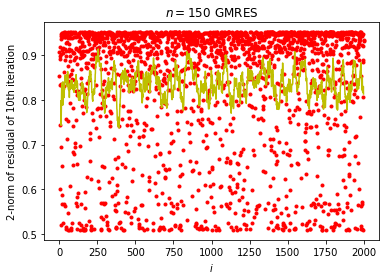

In [8]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[10:-1],AVG[10:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$n=150$ GMRES')
pp.savefig('GMRES.png')

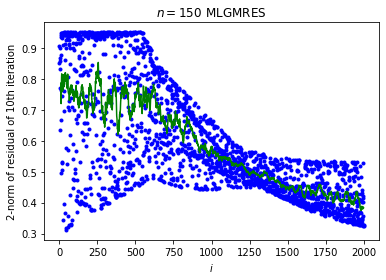

In [9]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('$n=150$ MLGMRES')
pp.savefig('MLGMRES.png')

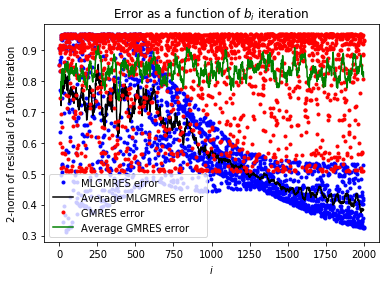

In [10]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('Error as a function of $b_i$ iteration ')
pp.legend(loc='best')
pp.savefig('Compare.png')

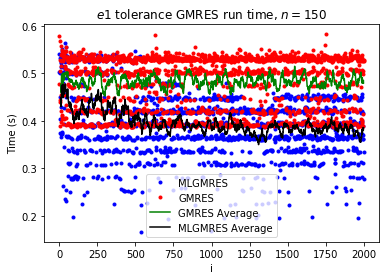

In [11]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')




pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n=150$')
pp.legend(loc='best')
pp.savefig('Runtime.png')